In [80]:
import os
import geopandas as gpd
import pandas as pd

In [79]:
roi_path = os.path.join('Boundary.gpkg')
roi = gpd.read_file(roi_path)
roi = roi.unary_union.__geo_interface__

In [6]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace
)

search = catalog.search(
    collections = ['sentinel-2-l2a'],
    datetime = '2025-03-01/2025-03-30',
    query = {'eo:cloud_cover': {'lt': 5}},
    intersects = roi
)

items = search.item_collection()
bands = list(items[0].assets.keys())

bands_list = [b for b in bands if b.startswith('B')]
print(bands_list)

items

['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']


In [7]:
import stackstac

stacked = stackstac.stack(items, epsg = 4326, assets = bands_list, chunksize = 1024)
stacked_med = stacked.median(dim = 'time', skipna = True, keep_attrs = True)

In [8]:
import rasterio as rio
import rioxarray

stacked_clip = stacked_med.rio.clip(gdf.geometry, gdf.crs)
stacked_final = stacked_clip * 0.0001
stacked_final

<xarray.DataArray 'stackstac-117b7ca069e4b1ae7e466611dd48d2f0' (band: 12,
                                                                y: 1177, x: 2097)> Size: 237MB
dask.array<mul, shape=(12, 1177, 2097), dtype=float64, chunksize=(1, 805, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U3 144B 'B01' ... 'B8A'
  * x                                        (x) float64 17kB 79.19 ... 79.38
  * y                                        (y) float64 9kB 14.66 ... 14.56
    proj:code                                <U10 40B 'EPSG:32644'
    s2:saturated_defective_pixel_percentage  float64 8B 0.0
    s2:processing_baseline                   <U5 20B '05.11'
    ...                                       ...
    title                                    (band) <U37 2kB 'Band 1 - Coasta...
    common_name                              (band) object 96B 'coastal' ... ...
    center_wavelength                        (band) float64 96B 0.443 ... 0.865
    full_width_half_max                      (band) float64 96B 0.027 ... 0.033
    epsg                                     int64 8B 4326
    spatial_ref                              int64 8B 0

In [9]:
gcp_path = os.path.join('Chapurapalli', 'gcps_chap.geojson')
gcps = gpd.read_file(gcp_path)

classes = {
    1: 'agri',
    2: 'barren',
    3: 'water',
    4: 'developed',
    5: 'forest'
}

gcps['class_name'] = gcps['class'].map(classes)
gcps.head(2)

,id,class,geometry,class_name
0,0_0,1,POINT (79.28646 14.60489),agri
1,0_1,1,POINT (79.28605 14.60442),agri


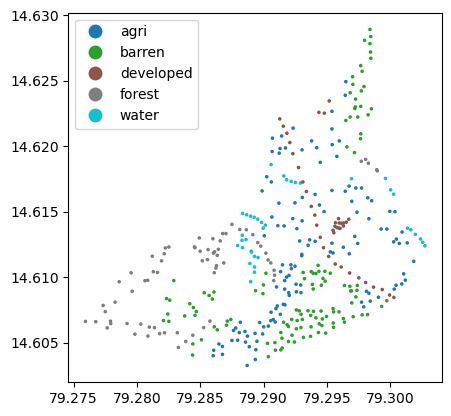

In [10]:
import matplotlib.pyplot as plt
import mapclassify

fig, ax = plt.subplots()
gcps.plot(ax = ax, column = 'class_name', legend = True, markersize = 2.5)

plt.show()

In [11]:
#Extract x, y coordinates for sampling of raster
x, y = gcps.geometry.x.to_xarray(), gcps.geometry.y.to_xarray()

sampling  = stacked_final.sel(x = x, y = y, method = 'nearest')
training_samples = pd.DataFrame(sampling.T, columns = bands_list)
training_samples['class'] = gcps['class']
training_samples = training_samples.join(gcps['class_name'], on = 'class')
training_samples.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,class,class_name
0,0.1260,0.1358,0.1612,0.1680,0.2223,0.4062,0.4496,0.4524,0.4963,0.3510,0.2608,0.4779,1,agri
1,0.1264,0.1338,0.1628,0.1672,0.2248,0.4103,0.4739,0.4848,0.4608,0.3641,0.2674,0.4832,1,agri
2,0.1261,0.1334,0.1584,0.1714,0.2235,0.3408,0.3871,0.4176,0.4556,0.3556,0.2744,0.4048,1,agri
3,0.1264,0.1326,0.1586,0.1536,0.2187,0.4105,0.4527,0.4652,0.4410,0.3155,0.2215,0.4850,1,agri
4,0.1260,0.1324,0.1652,0.1604,0.2216,0.4169,0.4764,0.4984,0.4963,0.3381,0.2437,0.4904,1,agri


In [12]:
X = training_samples.drop(columns = ['class', 'class_name'])
Y = training_samples['class']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 5, )

In [14]:
model = RandomForestClassifier(n_estimators=200)

prediction = model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print('Kappa', cohen_kappa_score(y1 = Y_test, y2 = y_pred))
print('confusion_matrix:', '\n', confusion_matrix(y_true = Y_test, y_pred = y_pred))

Kappa 0.909876079609463
confusion_matrix: 
 [[34  0  0  0  3]
 [ 0 42  0  1  0]
 [ 0  0 10  0  1]
 [ 0  1  0 12  0]
 [ 2  0  0  0 14]]


In [15]:
new_df = pd.DataFrame(columns = bands_list)

for i, j in enumerate(bands_list):
    value = stacked_final.isel(band = i).values.flatten()
    new_df[j] = value

In [16]:
new_df

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.1382,0.1356,0.1562,0.1590,0.2098,0.2650,0.2868,0.2904,0.3138,0.3172,0.2277,0.3114
1,0.1382,0.1423,0.1662,0.1661,0.2098,0.2650,0.2868,0.3092,0.3138,0.3172,0.2277,0.3114
2,0.1382,0.1422,0.1600,0.1662,0.2120,0.2719,0.2881,0.3008,0.3138,0.3155,0.2296,0.3201
3,0.1382,0.1358,0.1602,0.1592,0.2120,0.2719,0.2881,0.3042,0.3138,0.3155,0.2296,0.3201
4,0.1370,0.1421,0.1662,0.1698,0.2217,0.2748,0.2966,0.3166,0.3243,0.3276,0.2363,0.3226
...,...,...,...,...,...,...,...,...,...,...,...,...
2468164,0.1316,0.1392,0.1769,0.1443,0.1557,0.1255,0.1271,0.1229,0.1155,0.1105,0.1110,0.1191
2468165,0.1316,0.1395,0.1754,0.1429,0.1557,0.1255,0.1271,0.1202,0.1155,0.1105,0.1110,0.1191
2468166,0.1306,0.1384,0.1739,0.1414,0.1497,0.1216,0.1222,0.1167,0.1125,0.1107,0.1099,0.1147
2468167,0.1306,0.1388,0.1730,0.1393,0.1497,0.1216,0.1222,0.1169,0.1125,0.1107,0.1099,0.1147


In [17]:
predicted_lulc = model.predict(new_df)

In [18]:
classes

{1: 'agri', 2: 'barren', 3: 'water', 4: 'developed', 5: 'forest'}

In [19]:
lulc = predicted_lulc.reshape((stacked_final.shape[1], stacked_final.shape[2]))
lulc = lulc.astype('int16')

In [21]:
import xarray

lulc_projected = xarray.DataArray(lulc, 
                                  coords = {'x' : stacked_final.x , 'y' : stacked_final.y, 
                                            'epsg': 4326, 
                                            'proj:code': 'EPSG:32644'},
                                  dims = ('y', 'x'),
                                  name = 'LULC')

lulc_2 = lulc_projected.rio.write_crs('EPSG:4326')
lulc_2

<xarray.DataArray 'LULC' (y: 1177, x: 2097)> Size: 5MB
array([[5, 5, 5, ..., 4, 4, 5],
       [5, 5, 5, ..., 4, 4, 5],
       [5, 5, 5, ..., 4, 4, 5],
       ...,
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3]], shape=(1177, 2097), dtype=int16)
Coordinates:
  * x            (x) float64 17kB 79.19 79.19 79.19 79.19 ... 79.38 79.38 79.38
  * y            (y) float64 9kB 14.66 14.66 14.66 14.66 ... 14.56 14.56 14.56
    epsg         int64 8B 4326
    proj:code    <U10 40B 'EPSG:32644'
    spatial_ref  int64 8B 0

In [ ]:
lulc_2.rio.to_raster('lulc_4.tif')

In [51]:
labels = list(classes.values())  
colors = ['lightGreen', 'yellow', 'blue', 'red', 'darkGreen']

from matplotlib.colors import ListedColormap

cmap = ListedColormap(colors = colors)
labels

['agri', 'barren', 'water', 'developed', 'forest']

In [54]:
import matplotlib.patches as mpatches

patches = []

for i in range(5):
    c = mpatches.Patch(color = colors[i], label =  labels[i])
    patches.append(c)

patches

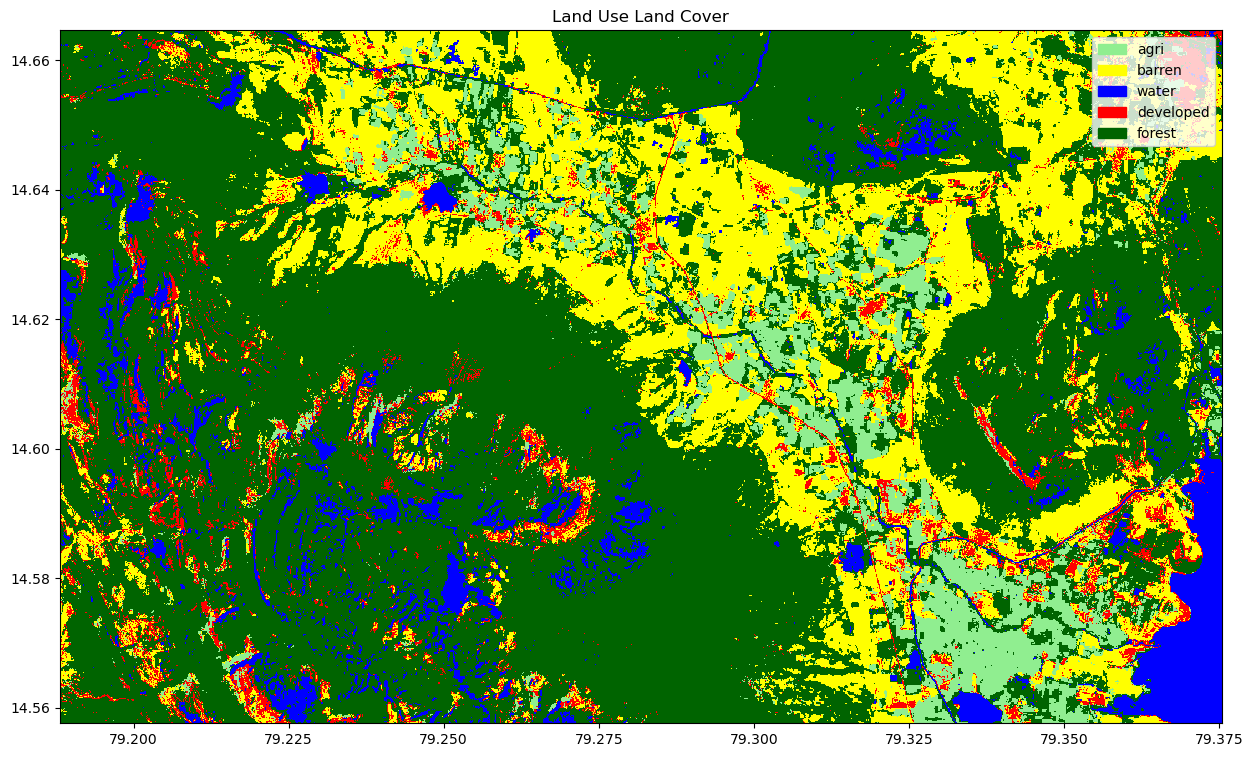

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 9)

lulc_2.plot.imshow(ax = ax, vmin = 1, vmax = 5, cmap = cmap, add_colorbar = False)

ax.legend(handles = patches)

ax.set_title('Land Use Land Cover', )
ax.set_xlabel('')

ax.set_ylabel('')

plt.show()

In [66]:
import leafmap

m = leafmap.Map()
m.add_basemap('SATELLITE')
m.add_raster(lulc_2, cmap = cmap , vmin = 1, vmax = 5, layer_name = 'LULC')
m

Map(center=[14.611094, 79.28178750000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

In [67]:
import numpy as np

class_counts = np.unique(lulc, return_counts = True)

area_table = pd.DataFrame(class_counts, index = [1, 2])
area_table = area_table.T
area_table['class'] = classes.values()
area_table.columns = ['class_number', 'Pixel Count', 'class']
area_table['area in ha'] = area_table['Pixel Count'] / 10000
area_table

,class_number,Pixel Count,class,area in ha
0,1,179634,agri,17.9634
1,2,532262,barren,53.2262
2,3,151650,water,15.1650
3,4,123886,developed,12.3886
4,5,1480737,forest,148.0737


<Axes: title={'center': 'Area in ha'}>

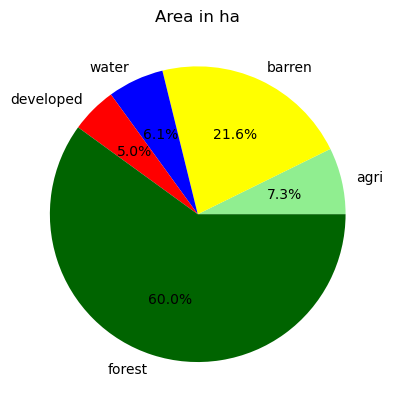

In [68]:
area_table.plot(
    kind='pie',
    y='area in ha',
    ylabel = '',
    labels=area_table["class"],  
    legend=False,                 
    autopct='%1.1f%%',            
    title="Area in ha",
    colormap = cmap
)